In [2]:
import imageio
import scipy.sparse as ss
import scipy.sparse.linalg as ssl
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
%matplotlib inline

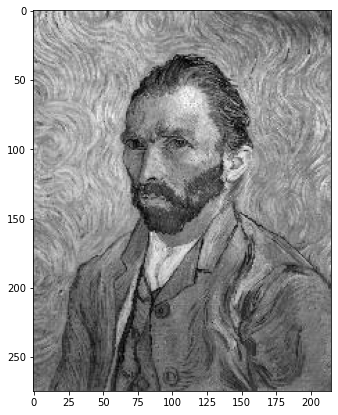

In [3]:
# Read image
u = imageio.imread('./vangogh1.png').mean(-1) / 255.
M, N = u.shape
plt.figure(figsize=(7,7))
plt.imshow(u, cmap="gray")

### Constructing the operators
All operators act on flattened images. In the lecture slides, you have the derivation why, e.g., the divergence is the negative adjoint of the gradient.

In [4]:
import math_tools

nabla = math_tools.spnabla(*u.shape)
div = -nabla.T
laplace = div @ nabla

### The nabla operator expects a flattened image (`u.ravel()`, see also `linear-operators.ipynb`), and returns the spatial derivatives stacked ontop of each other:

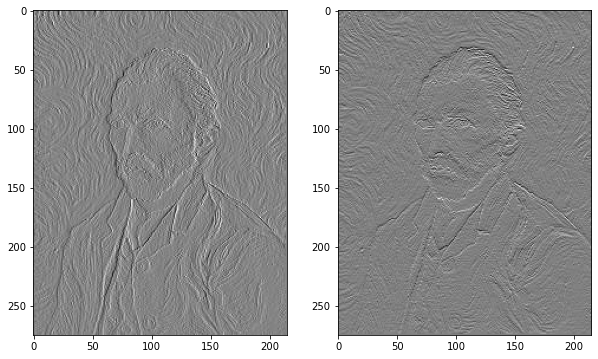

In [5]:
u_x, u_y = (nabla @ u.ravel()).reshape(2, *u.shape)

plt.figure(2, figsize=(10,10))
plt.subplot(121)
plt.imshow(u_x, cmap="gray")
plt.subplot(122)
plt.imshow(u_y, cmap="gray")

## Linear Isotropic Homogeneous Diffusion (using an explicit discretization of the PDE)

Linear: The diffusion tensor does not depend on the current state (image).

Isotropic: At any spatial location (pixel), the diffusion is the same in any spatial direction.

Homogeneous: The diffusion tensor does not depend on the spatial location (pixel).

In other words, the diffusion tensor $ D $ is the identity mapping.

The solution to the lin. iso. hom. heat equation is Gaussian filtering with $\sigma=2t$. Differences are due to the discretization of the PDE (the smaller $\Delta t$, the better). The explicit discretization scheme is only stable for $\Delta t < 1/4$. Play around with $\Delta t$!

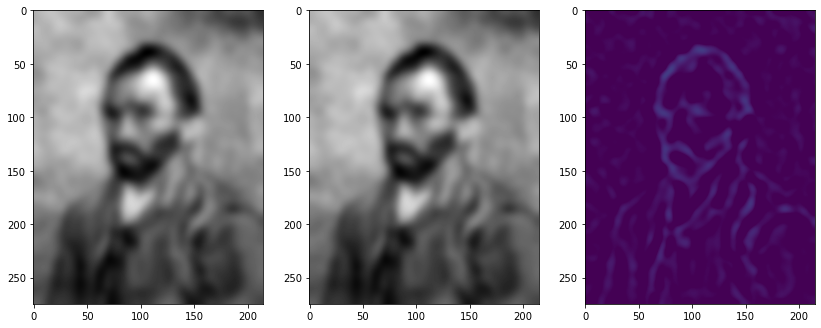

In [6]:
T = 10
# Stable for dt < 1/4
dt = 0.2
U = u.ravel()
t = 0
while t <= T:
    U = U + dt * laplace @ U
    t += dt

diffused = U.reshape(M, N)
filtered = gaussian_filter(u, np.sqrt(2 * T))

fig, ax = plt.subplots(1, 3, figsize=(14,7))
ax[0].imshow(diffused, cmap="gray")
ax[1].imshow(filtered, cmap='gray')
ax[2].imshow(100 * (diffused - filtered), vmin=0, vmax=1)

## Implicit PDE discretization
This scheme is stable for any $\Delta t > 0$, but this comes at the cost of having to solve a linear system. As with the explicit discretization, larger $\Delta t$ lead to an error with respect to the continuous-time solution (Gaussian filtering). Using a solving routine is always preferred to computing the inverse!

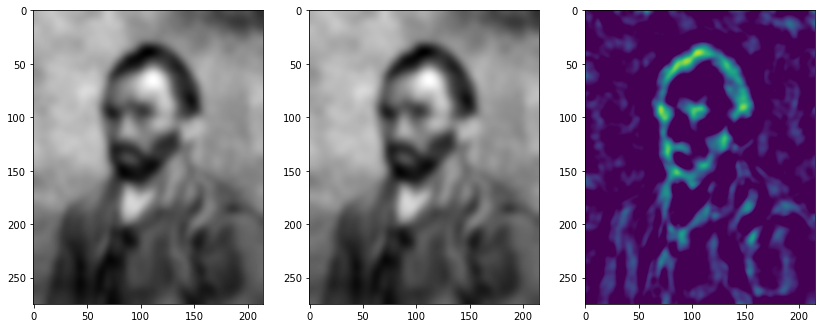

In [7]:
T = 10
dt = 2

# Operator for implicit discretization
A = ss.eye(M * N) + dt * nabla.T @ ss.eye(2 * M * N) @ nabla
U = u.ravel()
t = 0
while t <= T:
    U = ssl.spsolve(A, U)
    t += dt

diffused = U.reshape(M, N)
filtered = gaussian_filter(u, np.sqrt(2 * T))

fig, ax = plt.subplots(1, 3, figsize=(14,7))
ax[0].imshow(diffused, cmap="gray")
ax[1].imshow(filtered, cmap='gray')
ax[2].imshow(100 * (diffused - filtered), vmin=0, vmax=1)

## Linear Isotropic Inhomogeneous Diffusion

Inhomogeneous: The diffusion tensor (still a scalar at this point) depends on the spatial location.

Since the scheme is linear, we can precompute a pseudo-image that hold the diffusion strength for every pixel. Here, we use an "edge-stopping function" ($g$), that acts on the squared norm of the spatial gradient, and whose influence is controlled by a parameter, $\lambda$. In the visualization, the left plot shows the diffusion map for each pixel, where bright colors indicate strong diffusion.

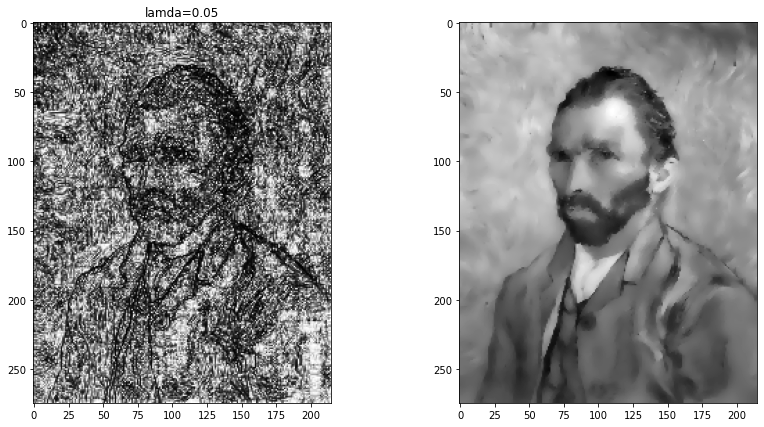

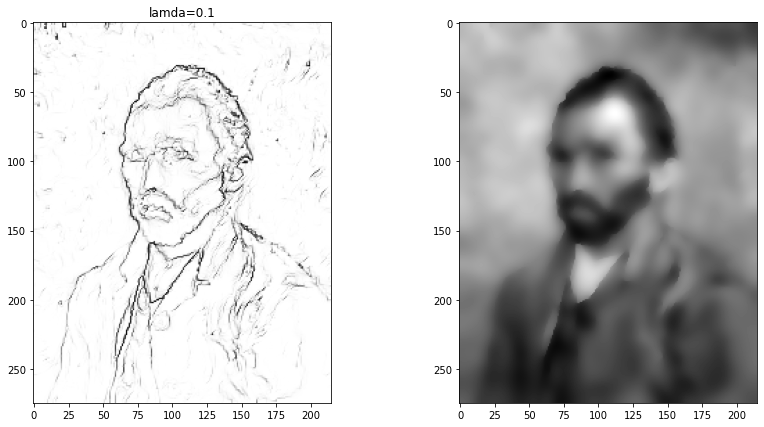

In [8]:
# Edge stopping function
def g(nabla_u, lamda):
    return 1 / (1 + (nabla_u ** 2).sum(0) / lamda ** 2)

U = u.ravel()
for lamda in [5e-2, 1e-1]:
    # Precompute diffusion tensor
    d = g((nabla @ U).reshape(2, U.size), lamda).reshape(M, N)
    D = d.reshape(-1)[:, None, None] * np.eye(2)[None]
    diags = [ss.diags(diag) for diag in (D[:, 0, 0], D[:, 1, 0], D[:, 1, 1])]
    DD = ss.bmat([diags[:2], diags[1:]])

    A = ss.eye(M * N) + dt * nabla.T @ DD @ nabla
    
    # Solve heat PDE
    t = 0
    while t <= T:
        U = ssl.spsolve(A, U)
        t += dt

    fig, ax = plt.subplots(1, 2, figsize=(14,7))
    ax[0].imshow(d, cmap='gray')
    ax[0].set_title(f'{lamda=}')
    ax[1].imshow(U.reshape(M,N), cmap='gray')

## Non-linear Isotropic Inhomogeneous Diffusion

Non-linear: Instead of pre-computing the diffusion map, we re-compute it at every iteration. In other words, the diffusion tensor (scalar) depends on the current solution.

This is the well-known Perona-Malik model. We use the same edge-stopping function as previously, but decrease $\lambda$. Since the image gets smoother over time, also the diffusion maps will become brighter over time (i.e. allowing for more diffusion). However, strong edges are retained very well.

[[0.00938308 0.00848057 0.00798095 ... 0.03031433 0.01534504 0.13337778]
 [0.04677973 0.02149569 0.06568016 ... 0.0399533  0.01523717 0.20641219]
 [0.00861541 0.17224025 0.05629748 ... 0.07517124 0.0165457  0.152991  ]
 ...
 [0.05441309 0.07165092 0.02715003 ... 0.15209637 0.34675377 0.96297668]
 [0.03070802 0.09423572 0.0461162  ... 0.1926524  0.20641219 1.        ]
 [0.8667111  0.0399533  0.17692674 ... 0.34675377 0.11715688 1.        ]]
[[[0.00938308 0.        ]
  [0.         0.00938308]]

 [[0.00848057 0.        ]
  [0.         0.00848057]]

 [[0.00798095 0.        ]
  [0.         0.00798095]]

 ...

 [[0.34675377 0.        ]
  [0.         0.34675377]]

 [[0.11715688 0.        ]
  [0.         0.11715688]]

 [[1.         0.        ]
  [0.         1.        ]]]
[<59125x59125 sparse matrix of type '<class 'numpy.float64'>'
	with 59125 stored elements (1 diagonals) in DIAgonal format>, <59125x59125 sparse matrix of type '<class 'numpy.float64'>'
	with 59125 stored elements (1 diagonals

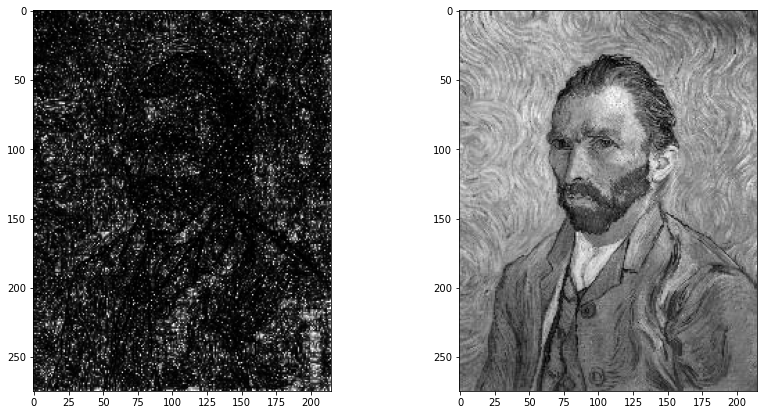

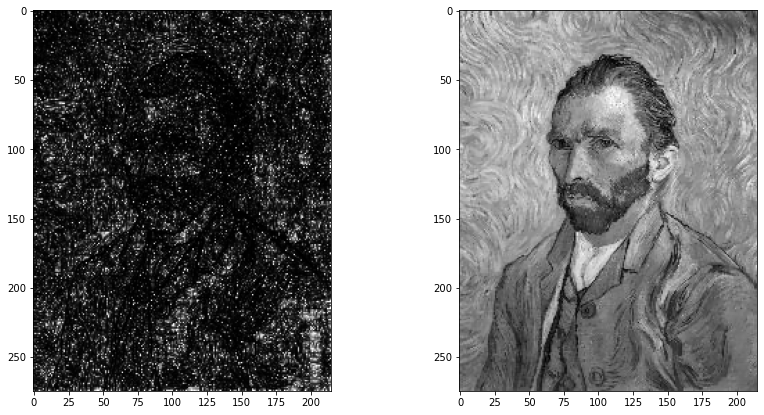

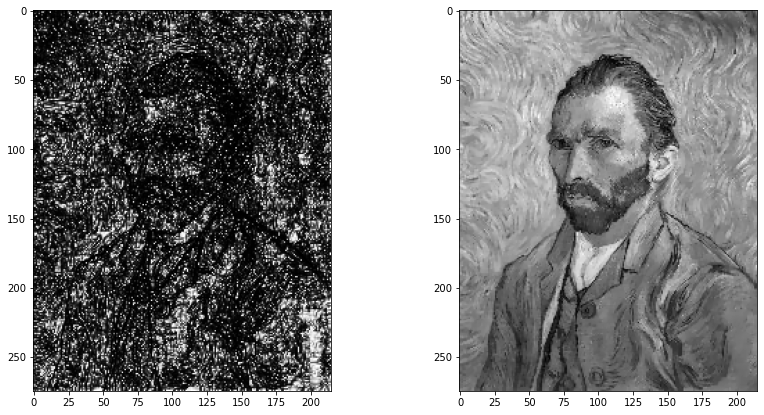

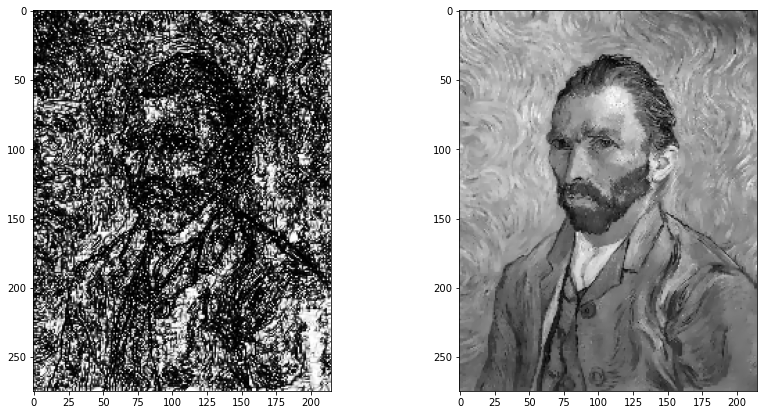

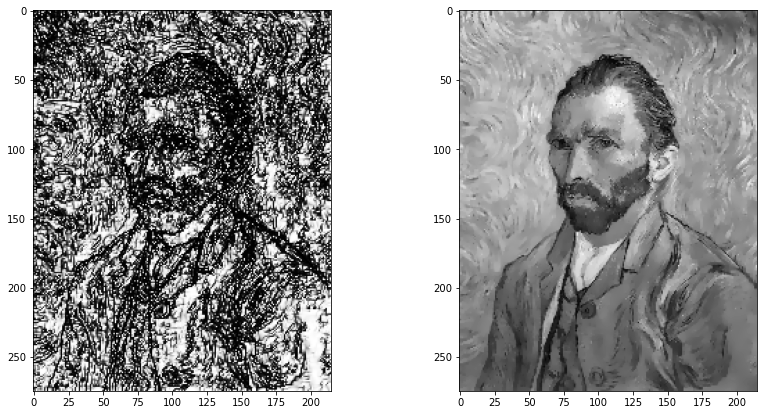

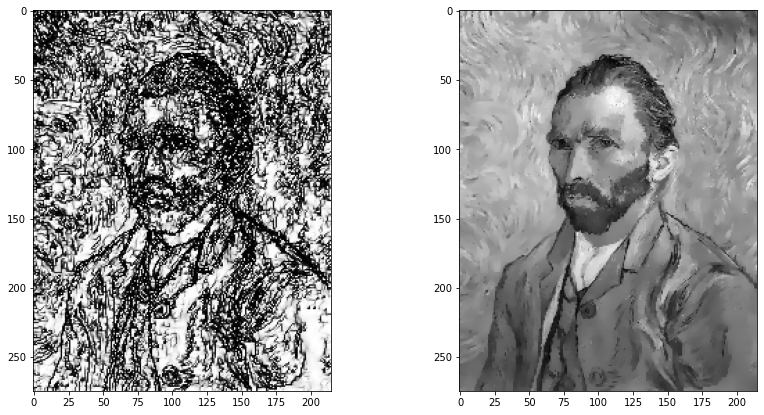

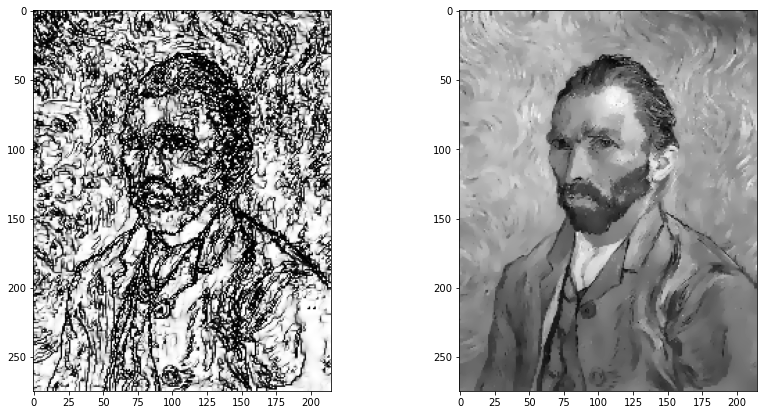

In [9]:
U = u.ravel()

lamda = 1.5e-2

d = g((nabla @ U).reshape(2, U.size), lamda).reshape(M, N)
D = d.reshape(-1)[:, None, None] * np.eye(2)[None]
fig, ax = plt.subplots(1, 2, figsize=(14,7))
a1 = ax[0].imshow(d, cmap='gray')
a2 = ax[1].imshow(U.reshape(M,N), cmap='gray')

t = 0
# Solve non-linear heat PDE
while t <= T:
    # Non-linear: At every iteration, we compute the diffusion tensor from the current image
    # The code is the same as before.
    d = g((nabla @ U).reshape(2, U.size), lamda).reshape(M, N)
    print(d)
    D = d.reshape(-1)[:, None, None] * np.eye(2)[None]
    print(D)
    diags = [ss.diags(diag) for diag in (D[:, 0, 0], D[:, 1, 0], D[:, 1, 1])]
    print(diags)
    DD = ss.bmat([diags[:2], diags[1:]])
    print(DD)
    A = ss.eye(M * N) + dt * nabla.T @ DD @ nabla

    U = ssl.spsolve(A, U)
    t += dt
    
    fig, ax = plt.subplots(1, 2, figsize=(14,7))
    ax[0].imshow(d, cmap='gray')
    ax[1].imshow(U.reshape(M,N), cmap='gray')

## Non-linear Anisotropic Inhomogeneous Diffusion

Anisotropic: The diffusion strength is not necessarily the same in the spatial directions.

In other words, here we utilize all three degrees of freedom in the diffusion tensor. This is hard to visualize, so we just show the strength in the two principal directions separately. The left plot shows the diffusion in the first principal direction ("x"-direction, horizontal), the middle plot in the second principal direction ("y"-direction, vertical). The scheme we are considering is coherence-enhancing diffusion. You have to implement the `ad.diffusion_tensor` function.

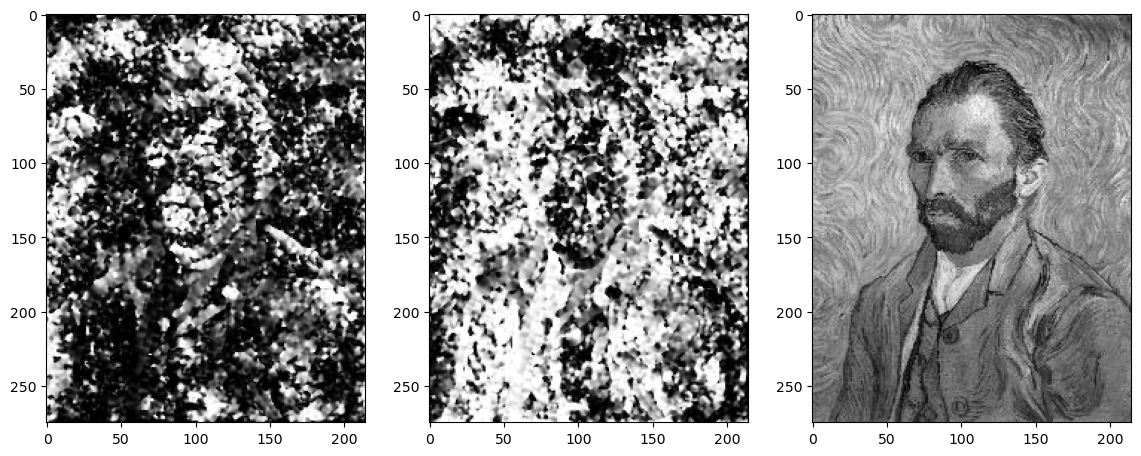

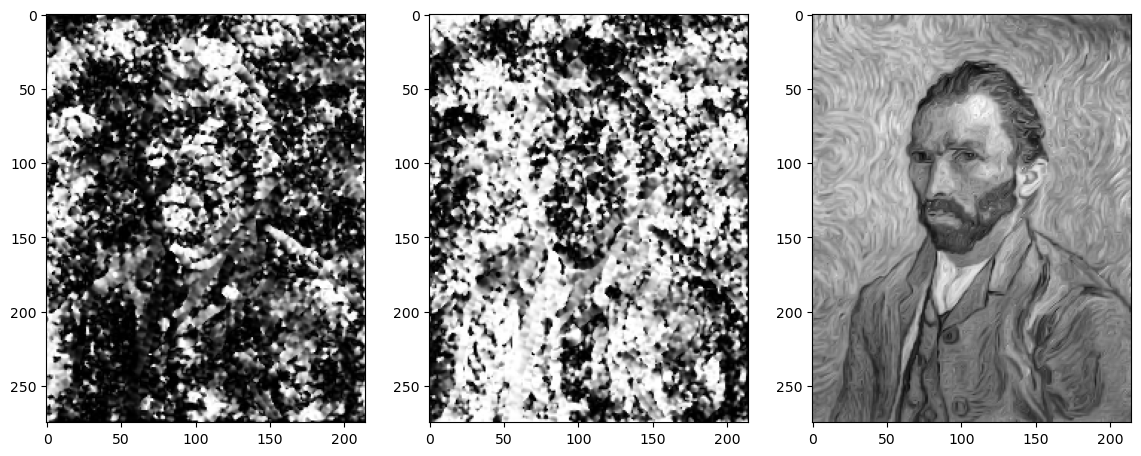

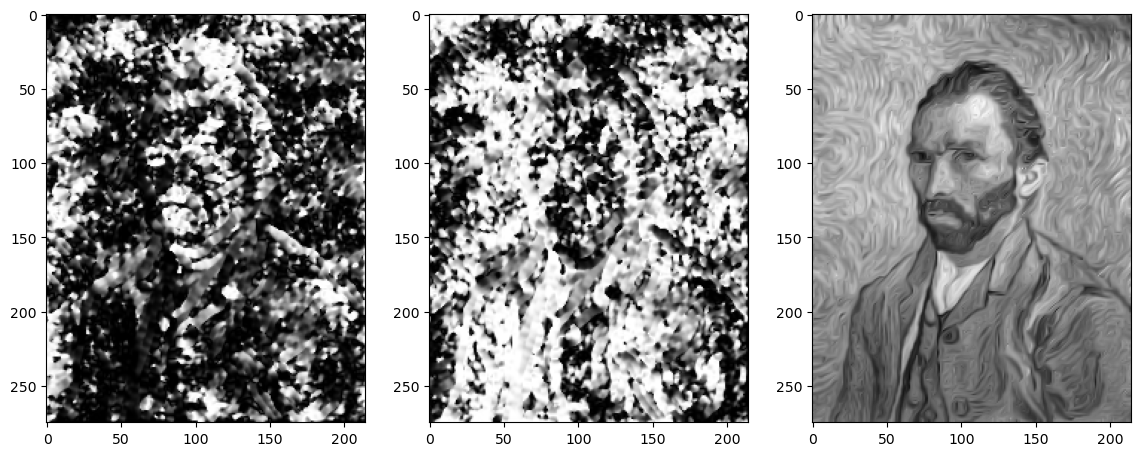

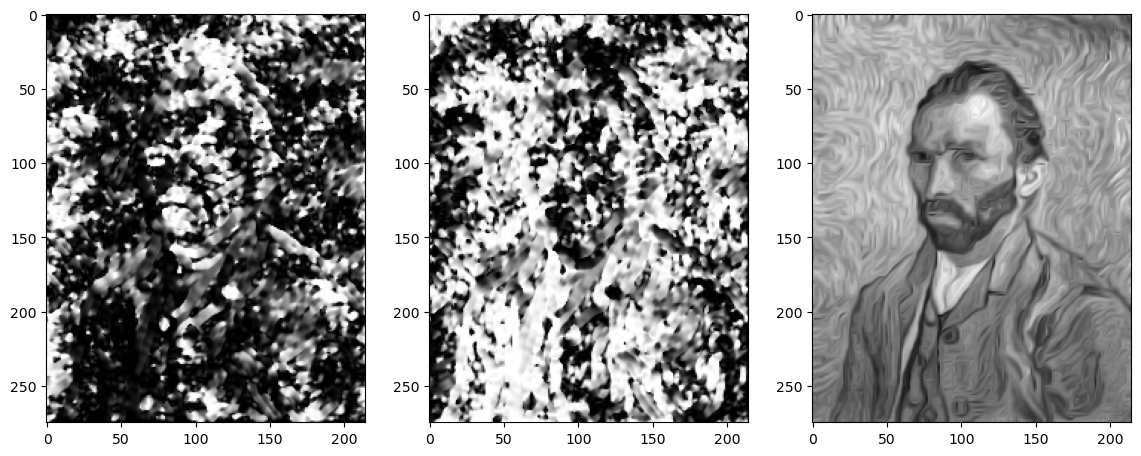

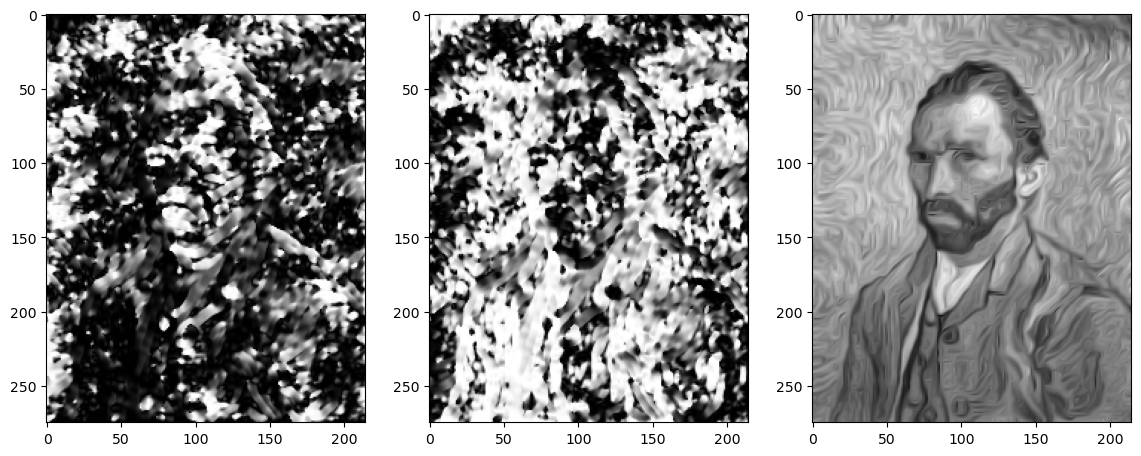

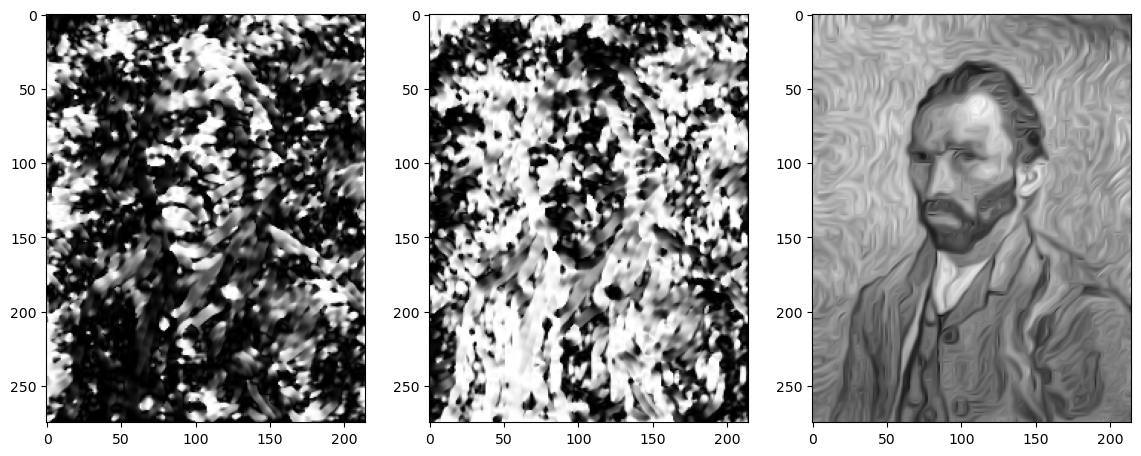

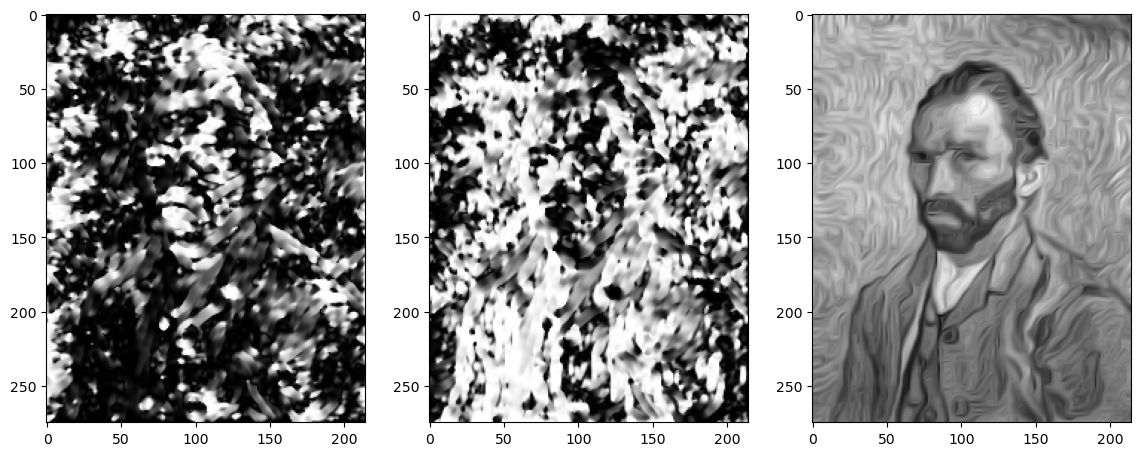

In [9]:
import anisotropic_diffusion as ad
U = u.ravel()

params = {
    'sigma_g': 1,
    'sigma_u': 0.7,
    'alpha': 0.0005,
    'gamma': 1e-4,
}

DD = ad.diffusion_tensor(U.reshape(*u.shape), **params, nabla=nabla, mode='ced')
fig, ax = plt.subplots(1, 3, figsize=(14,7))
a1 = ax[0].imshow(DD.diagonal()[:M*N].reshape(M,N), cmap='gray')
a2 = ax[1].imshow(DD.diagonal()[M*N:].reshape(M,N), cmap='gray')
a2 = ax[2].imshow(U.reshape(M,N), cmap='gray')
t = 0
while t <= T:
    DD = ad.diffusion_tensor(U.reshape(*u.shape), **params, nabla=nabla, mode='ced')
    A = ss.eye(M * N) + dt * nabla.T @ DD @ nabla

    U = ssl.spsolve(A, U)
    t += dt
    
    fig, ax = plt.subplots(1, 3, figsize=(14,7))
    a1 = ax[0].imshow(DD.diagonal()[:M*N].reshape(M,N), cmap='gray')
    a2 = ax[1].imshow(DD.diagonal()[M*N:].reshape(M,N), cmap='gray')
    ax[2].imshow(U.reshape(M,N), cmap='gray')

In [10]:
array = [[1, 2], [3, 4]]

# Create diagonal matrix from array
diagonal_matrix = np.diag(np.diag(array))
print(diagonal_matrix)

[[1 0]
 [0 4]]
